In [1]:
train_file = r"Temp\5d_allCombined.npz"
test_file = r"Temp\5d_allCombined.npz"

model_output_folder = r"Temp\Model"
plot_output_folder = r"Temp\Results"

In [2]:
import os
from local_vars import root_folder

train_fullpath = os.path.join(root_folder, train_file)
test_fullpath = os.path.join(root_folder, test_file)

model_output_fullpath = os.path.join(root_folder, model_output_folder)
plot_output_fullpath = os.path.join(root_folder, plot_output_folder)

In [3]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
import tensorflow
from tensorflow import keras
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
from datetime import datetime

Using TensorFlow backend.


In [4]:
# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=image_shape)
    # target image input
    in_target_image = Input(shape=image_shape)
    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [5]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [6]:
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

In [7]:
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(5, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

In [8]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

In [9]:
# load and prepare training images
def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [10]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [11]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [12]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    pyplot.title('plot %06d' % (step+1))
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i,:,:,2])
    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i,:,:,0])
    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i,:,:,0])
    # save plot to file
    
    #plot_filename = os.path.join(model_output_fullpath,'plot_%06d.png' % (step+1))
    #pyplot.savefig(plot_filename)
    pyplot.show()
    pyplot.close()
    # save the generator model
    model_filename = 'model_%06d.png' % (step+1)
    #model_filename = os.path.join(model_output_fullpath,'model_%06d.png' % (step+1))
    g_model.save(model_filename)
    print('>Saved: %s at %s' % (model_filename, datetime.now().strftime("%H:%M:%S.%f")))

In [13]:
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        if (i+1) % bat_per_epo == 0:
                    print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)

In [14]:
# load image data
dataset = load_real_samples(train_fullpath)
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]

Loaded (459, 512, 512, 5) (459, 512, 512, 5)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


C:\Users\14sgp\Documents\Workspace\tf-gpu\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>459, d1[0.942] d2[0.331] g[3.784]
>918, d1[0.312] d2[0.132] g[3.845]
>1377, d1[0.011] d2[0.100] g[10.876]
>1836, d1[0.141] d2[0.210] g[3.808]
>2295, d1[0.894] d2[0.279] g[3.991]
>2754, d1[0.147] d2[0.026] g[8.600]
>3213, d1[0.157] d2[0.173] g[3.714]
>3672, d1[0.137] d2[0.070] g[4.515]
>4131, d1[0.008] d2[0.017] g[12.241]
>4590, d1[0.203] d2[0.046] g[4.196]


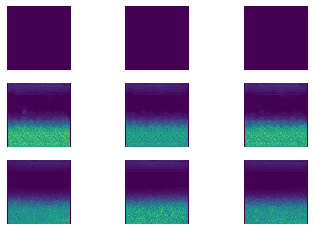

>Saved: model_004590.png at 13:09:03.859643
>5049, d1[0.189] d2[0.155] g[4.426]
>5508, d1[0.167] d2[0.182] g[4.295]
>5967, d1[0.038] d2[0.012] g[5.804]
>6426, d1[0.001] d2[0.012] g[12.739]
>6885, d1[0.112] d2[0.105] g[4.290]
>7344, d1[0.065] d2[0.086] g[5.263]
>7803, d1[0.028] d2[0.130] g[5.313]
>8262, d1[0.153] d2[0.020] g[5.601]
>8721, d1[0.595] d2[0.100] g[4.338]
>9180, d1[0.840] d2[0.010] g[5.161]


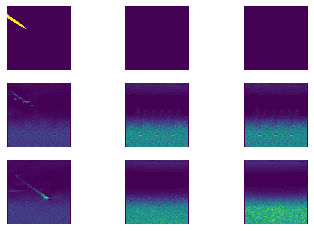

>Saved: model_009180.png at 13:24:44.957465
>9639, d1[0.101] d2[0.008] g[6.021]
>10098, d1[0.093] d2[0.176] g[5.561]
>10557, d1[0.021] d2[0.381] g[8.927]
>11016, d1[0.099] d2[0.131] g[4.426]
>11475, d1[0.127] d2[0.284] g[5.038]
>11934, d1[0.001] d2[0.023] g[9.006]
>12393, d1[0.006] d2[0.019] g[5.232]
>12852, d1[0.020] d2[0.008] g[6.290]
>13311, d1[0.000] d2[0.013] g[11.847]
>13770, d1[0.015] d2[0.152] g[5.902]


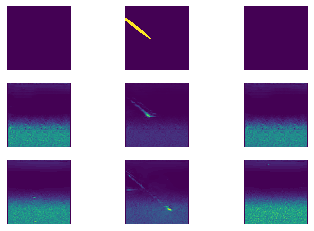

>Saved: model_013770.png at 13:40:32.304516
>14229, d1[0.003] d2[0.025] g[5.253]
>14688, d1[0.004] d2[0.025] g[5.928]
>15147, d1[0.168] d2[0.107] g[4.715]
>15606, d1[0.343] d2[0.053] g[4.802]
>16065, d1[0.095] d2[0.020] g[6.614]
>16524, d1[0.028] d2[0.039] g[4.985]
>16983, d1[0.051] d2[0.019] g[5.207]
>17442, d1[0.003] d2[0.105] g[5.176]
>17901, d1[0.048] d2[0.005] g[6.285]
>18360, d1[0.277] d2[0.111] g[5.917]


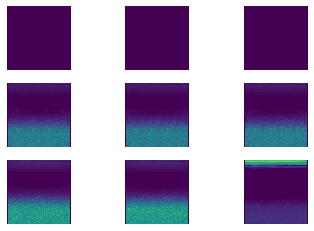

>Saved: model_018360.png at 13:56:13.058062


In [15]:
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset, 40)

In [16]:
model = load_model('model_004590.h5')
# select random example
[X1, X2] = load_real_sample(test_fullpath)
#ix = randint(0, len(X1), 1)
ix = [309]
print(ix)
src_image, tar_image = dataset[0][ix], dataset[1][ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

NameError: name 'load_model' is not defined